In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader


# Load dataset
data = pd.read_csv("/content/customers.csv")
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
data.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [8]:
# Drop ID column as it's not useful for classification
if "ID" in data.columns:
    data = data.drop(columns=["ID"])
# Handle missing values
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)



# Encode categorical variables
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])


# Encode target variable
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])  # A, B, C, D -> 0, 1, 2, 3


# Split features and target
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


#Name: Nitheesh Kumar B
#Register Number: 212224230189
class PeopleClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



input_size = X_train.shape[1]
num_classes = 4

model = PeopleClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")



train_model(model, train_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Loss: 675.5903
Epoch 2/50, Loss: 643.4174
Epoch 3/50, Loss: 638.7712
Epoch 4/50, Loss: 635.9752
Epoch 5/50, Loss: 633.3724
Epoch 6/50, Loss: 631.7859
Epoch 7/50, Loss: 630.6255
Epoch 8/50, Loss: 629.6789
Epoch 9/50, Loss: 628.5085
Epoch 10/50, Loss: 627.6548
Epoch 11/50, Loss: 627.0771
Epoch 12/50, Loss: 626.4769
Epoch 13/50, Loss: 625.6321
Epoch 14/50, Loss: 625.2413
Epoch 15/50, Loss: 624.4231
Epoch 16/50, Loss: 623.7812
Epoch 17/50, Loss: 623.0301
Epoch 18/50, Loss: 621.5563
Epoch 19/50, Loss: 622.2298
Epoch 20/50, Loss: 620.4522
Epoch 21/50, Loss: 620.4597
Epoch 22/50, Loss: 619.8561
Epoch 23/50, Loss: 619.2193
Epoch 24/50, Loss: 618.3715
Epoch 25/50, Loss: 618.6415
Epoch 26/50, Loss: 617.1103
Epoch 27/50, Loss: 617.3555
Epoch 28/50, Loss: 616.8427
Epoch 29/50, Loss: 616.1628
Epoch 30/50, Loss: 615.5967
Epoch 31/50, Loss: 614.9035
Epoch 32/50, Loss: 615.0338
Epoch 33/50, Loss: 614.4577
Epoch 34/50, Loss: 613.0472
Epoch 35/50, Loss: 614.0045
Epoch 36/50, Loss: 613.1626
E

In [9]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[269 100  87 128]
 [156 141 112  81]
 [ 97  90 227  58]
 [154  31  29 379]]


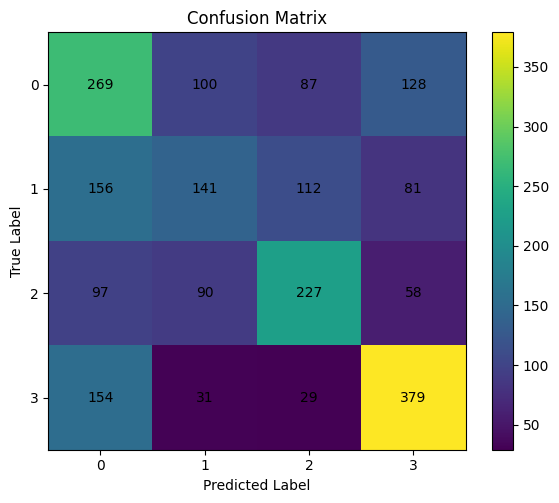

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add values inside the matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.tight_layout()
plt.show()


In [12]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in label_encoder.classes_]))

              precision    recall  f1-score   support

           0       0.40      0.46      0.43       584
           1       0.39      0.29      0.33       490
           2       0.50      0.48      0.49       472
           3       0.59      0.64      0.61       593

    accuracy                           0.47      2139
   macro avg       0.47      0.47      0.46      2139
weighted avg       0.47      0.47      0.47      2139



In [13]:
sample = np.array([[1, 0, 45, 1, 0, 2, 3, 4, 1]])
sample = scaler.transform(sample)
sample = torch.tensor(sample, dtype=torch.float32)

output = model(sample)
_, prediction = torch.max(output, 1)

print("Predicted Segment:", label_encoder.inverse_transform(prediction.numpy()))

Predicted Segment: [0]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
